# OpenVINO ONNX demo

This tutorial demostrates step-by-step instructions to perform inference on a PyTorch model using [OpenVINO](https://github.com/openvinotoolkit/openvino)

The PyTorch model is converted to ONNX and loaded with OpenVINO. The model is pretrained on [CityScapes](https://www.cityscapes-dataset.com). The model source is https://github.com/ekzhang/fastseg

NOTE: This is a work-in-progress tutorial. 

### Settings

In [1]:
# The filenames of the downloaded and converted models
base_model_name = "fastseg"
model_fname = base_model_name + ".pth"
onnx_fname = base_model_name + ".onnx"
ir_fname = base_model_name + ".xml"

### Install OpenVINO and the required Python packages

Download and Install the required packages for this demo. If you use OSX, change this cell to use the command to install PyTorch for OSX.

There may be some errors in the output because of version conflicts. The notebook should work fine despite these version conflicts.

After running this cell and installing the packages, you can delete this cell or comment out the contents.

In [ ]:
# OpenVINO
!pip install --upgrade --quiet --index-url https://test.pypi.org/simple --extra-index-url https://pypi.org/simple openvino-dev

# PyTorch
## Windows and Linux
!pip install torch==1.5.1+cpu torchvision==0.6.1+cpu -f https://download.pytorch.org/whl/torch_stable.html

## OSX
# pip install torch==1.5.1 torchvision==0.6.1

# Model specific dependencies
!pip install -U --quiet numpy==1.18.5 geffnet==0.9.8 fastseg onnx

## Image Segmentation with Fastseg

### Import the PyTorch Library and Fastseg

In [2]:
import os
import shutil
import subprocess
import time
import urllib
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from fastseg import MobileV3Large

### Download the Fastseg Model

This downloads and loads the model and pretrained weights. It may take some time.

In [3]:
print("Downloading the Fastseg model (if it has not been downloaded before)....")
model = MobileV3Large.from_pretrained().cpu().eval()
model.eval()
print("Loaded PyTorch Fastseg model")

# Save the model
if not os.path.exists(model_fname):
    print("\nSaving the model")
    torch.save(model.state_dict(), model_fname)
    print(f"Model saved at {model_fname}")

Loading pretrained model mobilev3large-lraspp with F=128...
Loaded PyTorch Fastseg model


### Create ONNX model

In [4]:
if not os.path.exists(onnx_fname):
    dummy_input = torch.randn(1, 3, 512, 1024)
    torch.onnx.export(model, dummy_input, onnx_fname, opset_version=11)
    print(f"ONNX model exported to {onnx_fname}.")
else:
    print(f"ONNX model {onnx_fname} already exists.")

ONNX model fastseg.onnx already exists.


### Convert the Model to IR

In [5]:
# Get the path to the Model Optimizer script
import mo_onnx

mo_path = str(Path(mo_onnx.__file__).with_name("mo.py"))

In [6]:
if not os.path.exists(ir_fname):
    print('Exporting ONNX model to IR...')
    ! python $mo_path --input_model $onnx_fname --input_shape "[1,3, 512,1024]" --data_type FP16 --output_dir . --model_name $base_model_name
    print(f'ONNX model exported to IR model: {ir_fname}')
else:
    print(f'IR model {ir_fname} already exists.')

IR model fastseg.xml already exists.


### Define Preprocessing and Display Functions

In [7]:
def normalize(image: np.ndarray) -> np.ndarray:
    """Normalize the image to the given mean and standard deviation for CityScapes models."""
    image = image.astype(np.float32)
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    image /= 255.0
    image -= mean
    image /= std
    return image


def show_image_and_result(image: np.ndarray, result: np.ndarray):
    fig, ax = plt.subplots(1, 2, figsize=(25, 8))
    ax[0].imshow(image)
    ax[1].imshow(result)
    for a in ax:
        a.axis("off")

### Load and Pre-process an Input Image

---




In [8]:
# image source: https://www.flickr.com/people/roland/ via https://storage.googleapis.com/openimages/web/visualizer/index.html?set=train&type=segmentation&r=false&c=%2Fm%2F0k4j&id=531b67238c25813b CC BY 2.0
image_url = "https://c4.staticflickr.com/4/3901/14855908765_75af9fac24_o.jpg"
urllib.request.urlretrieve(image_url, "image.jpg")
image = cv2.cvtColor(cv2.imread("image.jpg"), cv2.COLOR_BGR2RGB)
resized_image = cv2.resize(image, (1024, 512))
normalized_image = normalize(resized_image)
input_image = np.expand_dims(np.transpose(normalized_image, (2, 0, 1)), 0).astype(
    np.float32
)  # Convert the image shape to shape expected by network
input_image_tensor = torch.as_tensor(input_image).float()

### Load the OpenVINO IR network and Run Inference on the ONNX model

Inference Engine can load ONNX models directly. We first load the ONNX model, do inference and show the results. After that we load the model that was converted to Intermediate Representation (IR) with Model Optimizer and do inference on that model and show the results.

#### 1. ONNX model in Inference Engine

In [9]:
from openvino.inference_engine import IECore

# Load network to the plugin
ie = IECore()
net_onnx = ie.read_network(model="fastseg.onnx")
exec_net_onnx = ie.load_network(network=net_onnx, device_name="CPU")

input_layer_onnx = next(iter(exec_net_onnx.input_info))
output_layer_onnx = next(iter(exec_net_onnx.outputs))

# Run the Inference on the Input image...
res_onnx = exec_net_onnx.infer(inputs={input_layer_onnx: input_image})
res_onnx = res_onnx[output_layer_onnx]

C:\Users\havanden\code\openvino-notebooks\onnx_inference_convert\onnx_env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


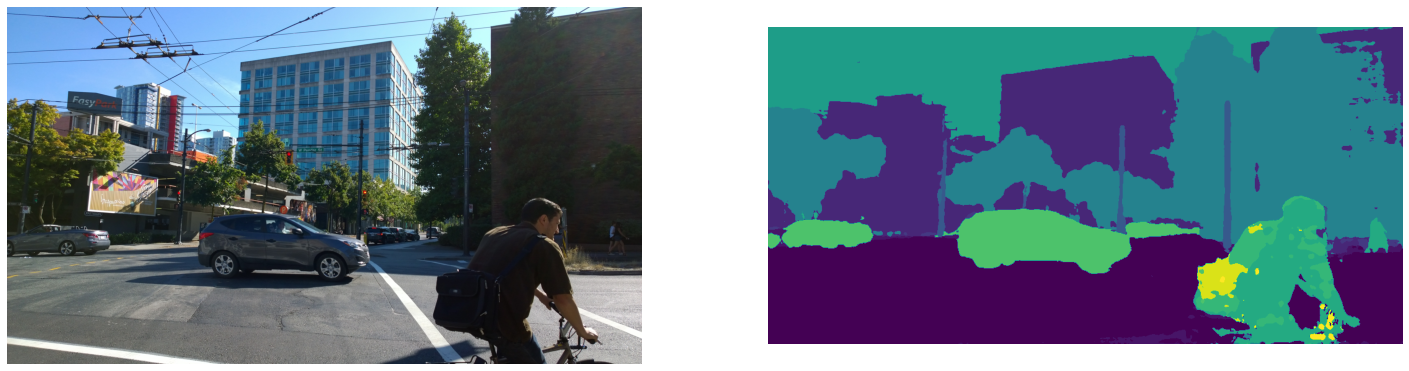

In [10]:
result_mask_onnx = np.squeeze(np.argmax(res_onnx, axis=1))
show_image_and_result(image, result_mask_onnx)

#### 2. IR model in Inference Engine

In [11]:
from openvino.inference_engine import IECore

# Load network to the plugin
ie = IECore()
net_ir = ie.read_network(model=ir_fname)
exec_net_ir = ie.load_network(network=net_ir, device_name="CPU")

input_layer_ir = next(iter(exec_net_ir.input_info))
output_layer_ir = next(iter(exec_net_ir.outputs))

# Run the Inference on the Input image...
res_ir = exec_net_ir.infer(inputs={input_layer_ir: input_image})
res_ir = res_ir[output_layer_ir]

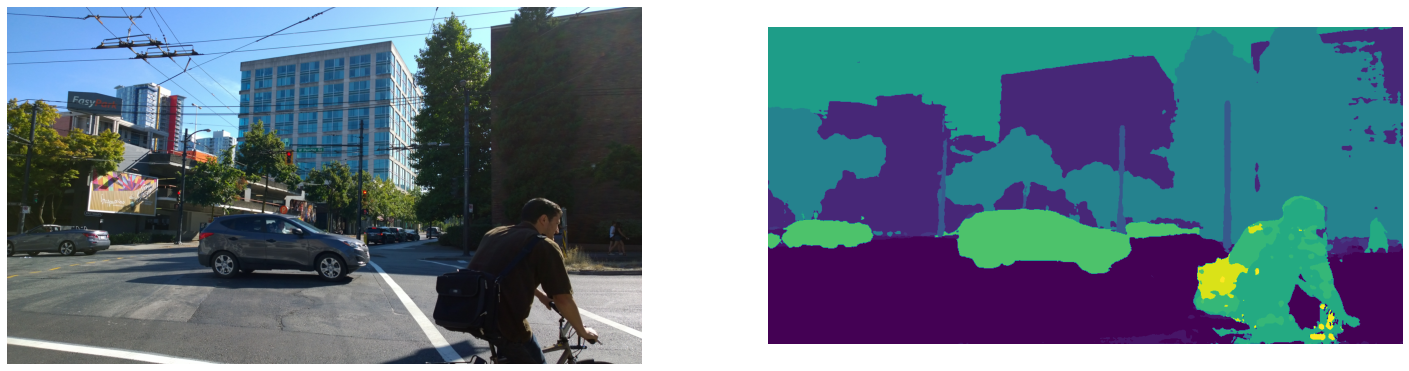

In [12]:
result_mask_ir = np.squeeze(np.argmax(res_ir, axis=1))
show_image_and_result(image, result_mask_ir)

## PyTorch Comparison

Do inference on the PyTorch model to verify that the output visually looks the same as the ONNX/IR models.

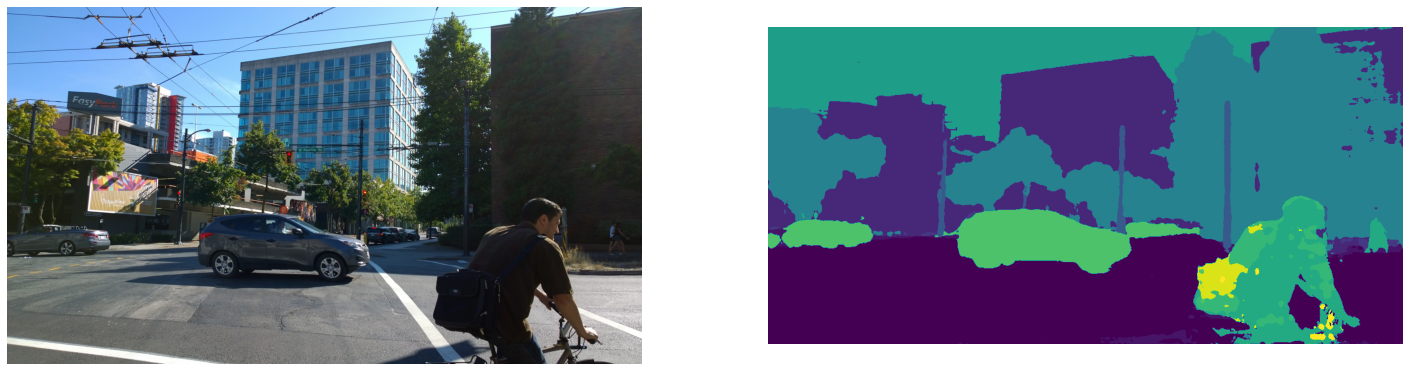

In [13]:
result_torch = model(input_image_tensor)
result_mask_torch = torch.argmax(result_torch, dim=1).squeeze(0)
show_image_and_result(image, result_mask_torch)

## Performance comparison

Measure the time it takes to do inference on five images. This gives an indication of performance. For more accurate benchmarking, use the [OpenVINO benchmark tool](https://github.com/openvinotoolkit/openvino/tree/master/inference-engine/tools/benchmark_tool). Note that many optimizations are possible to improve the performance. 

In [14]:
num_images = 5

start = time.perf_counter()
for _ in range(num_images):
    exec_net_onnx.infer(inputs={input_layer_onnx: input_image})
end = time.perf_counter()
time_onnx = end - start
print(f'ONNX model in Inference Engine/CPU: {time_onnx/num_images:.3f} seconds per image, FPS: {num_images/time_onnx:.2f}')

start = time.perf_counter()
for _ in range(num_images):
    exec_net_ir.infer(inputs={input_layer_ir: input_image})
end = time.perf_counter()
time_ir = end - start
print(f'IR model in Inference Engine/CPU: {time_ir/num_images:.3f} seconds per image, FPS: {num_images/time_ir:.2f}')

# Uncomment these lines for GPU performance stats
#
# exec_net_onnx_gpu = ie.load_network(network=net_ir, device_name="GPU")
# start = time.perf_counter()
# for _ in range(num_images):
#     exec_net_onnx_gpu.infer(inputs={input_layer_onnx: input_image})
# end = time.perf_counter()
# time_onnx_gpu = end - start
# print(f'ONNX model in Inference Engine/GPU: {time_onnx_gpu/num_images:.3f} seconds per image, FPS: {num_images/time_onnx_gpu:.2f}')

# exec_net_ir_gpu = ie.load_network(network=net_ir, device_name="GPU")
# start = time.perf_counter()
# for _ in range(num_images):
#     exec_net_ir_gpu.infer(inputs={input_layer_ir: input_image})
# end = time.perf_counter()
# time_ir_gpu = end - start
# print(f'IR model in Inference Engine/GPU: {time_ir_gpu/num_images:.3f} seconds per image, FPS: {num_images/time_ir_gpu:.2f}')


start = time.perf_counter()
for _ in range(num_images):
    model(input_image_tensor)
end = time.perf_counter()
time_torch = end - start
print(f'PyTorch model on CPU: {time_torch/num_images:.3f} seconds per image, FPS: {num_images/time_torch:.2f}')

ONNX model in Inference Engine/CPU: 0.252 seconds per image, FPS: 3.96
IR model in Inference Engine/CPU: 0.369 seconds per image, FPS: 2.71
PyTorch model on CPU: 3.634 seconds per image, FPS: 0.28


**Show CPU Information for reference**

In [15]:
try:
    import cpuinfo
    print(cpuinfo.get_cpu_info()['brand_raw'])
except:  # OpenVINO installs cpuinfo, but if a different version is installed the command above may not work
    import platform
    print(platform.processor())

Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz


# References

* PIP install openvino-dev: https://github.com/openvinotoolkit/openvino/blob/releases/2021/3/docs/install_guides/pypi-openvino-dev.md
* OpenVINO ONNX support: https://docs.openvinotoolkit.org/latest/openvino_docs_IE_DG_ONNX_Support.html
